# Clipping vs Sampling in iDP-SGD

## Define Setup


In [87]:
## Load Imports

from opacus_new import PrivacyEngine
from opacus_new.accountants import RDPAccountant
from opacus_new.validators.module_validator import ModuleValidator

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision.models as models

import numpy as np

from types import SimpleNamespace
from tqdm import tqdm
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", message="Secure RNG turned off.*")
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [88]:
## Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, num_samples=50_000, height=32, width=32, num_features=3, transform=None, target_transform=None):
        self.data = (255 * np.random.rand(num_samples, height, width, num_features)).astype(np.uint8)
        self.targets = torch.randint(0, 10, (num_samples,))
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        target = self.targets[idx]

        # Apply transformations if any
        if self.transform:
            sample = self.transform(sample)

        if self.target_transform:
            target = self.target_transform(target)

        return sample, target
    
    @classmethod
    def from_dataset(cls, dataset):
        return cls(data=dataset.data,
                targets=dataset.targets,
                transform=dataset.transform,
                target_transform=dataset.target_transform)

In [89]:
## Define a custom model class

class DummyResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.model = models.resnet18(num_classes=num_classes)

    def forward(self, x):
        return self.model(x)


In [90]:

def make_private(model, train_loader, pp_budgets, args):
    modulevalidator = ModuleValidator()
    model = modulevalidator.fix_and_validate(model)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    privacy_engine = PrivacyEngine(accountant=args.accountant,
                                   individualize=args.individualize,
                                   weights=args.weights,
                                   pp_budgets=pp_budgets)
    if args.adapt_weights_to_budgets:
        private_model, private_optimizer, private_loader = privacy_engine \
            .make_private_with_epsilon(module=model,
                                       optimizer=optimizer,
                                       data_loader=train_loader,
                                       target_epsilon=min(pp_budgets),
                                       target_delta=args.target_delta,
                                       epochs=args.epochs,
                                       max_grad_norm=args.max_grad_norm,
                                       optimal=True,
                                       max_alpha=10_000)
                                    #    numeric=True)
    else:
        private_model, private_optimizer, private_loader = privacy_engine \
            .make_private(module=model,
                          optimizer=optimizer,
                          data_loader=train_loader,
                          noise_multiplier=args.noise_multiplier,
                          max_grad_norm=args.max_grad_norm)

    if args.individualize == 'clipping':
        return{
            "budgets": list(np.unique(np.array(pp_budgets))),
            "max_grad_norms": privacy_engine.weights,
            "sample_rate": [1 / len(private_loader)] * len(privacy_engine.weights),
            "noise_multiplier": [private_optimizer.noise_multiplier] * len(privacy_engine.weights)
        }
    elif args.individualize == 'sampling':
        return{
            "budgets": list(np.unique(np.array(pp_budgets))),
            "max_grad_norms": [args.max_grad_norm] * len(privacy_engine.weights),
            "sample_rate":privacy_engine.weights,
            "noise_multiplier":[private_optimizer.noise_multiplier] * len(privacy_engine.weights)
        }
    else:
        return

In [91]:
def compute_epsilon_delta(noise_multiplier, deltas, iterations, sampling_rate, clipping_norm):
    accountant = RDPAccountant()
    for _ in range(int(iterations)):
        accountant.step(noise_multiplier=noise_multiplier * 1/clipping_norm, sample_rate=sampling_rate)
    epsilons = []
    deltas2 = []
    for delta in deltas:
        epsilon = accountant.get_epsilon(delta)
        epsilons.append(epsilon)
        deltas2.append(delta)
    return epsilons, deltas2

## Define Experiment

In [92]:
args = SimpleNamespace(
    accountant="rdp",  # Options: "rdp", "gdp", etc.
    individualize="sampling", # "sampling",  # Options: None, "clipping", "sampling"
    weights=None,  # Should be a list or None
    adapt_weights_to_budgets=True,  # Whether to adapt weights to budgets
    target_delta=1e-12,  # Default delta value for DP
    epochs=5,  # Number of training epochs
    max_grad_norm=1,  # Clipping norm for DP-SGD
    # noise_multiplier=1.0,  # Noise multiplier for DP
    n_data=50000,  # Number of data points
)
dummy_train_loader = DataLoader(CustomDataset(num_samples=args.n_data), batch_size=128, shuffle=True)
dummy_model = DummyResNet18()

# epsilons_1 = np.linspace(1, 100, 20)
# epsilon_2 = 10S
# portion_size_1 = np.linspace(0.05, 0.95, 19)
# deltas = np.linspace(1e-10, 1-1e-10, 20)

epsilons_1 = np.linspace(4, 16, 4)
epsilon_2 = 32/4
portion_size_1 = np.linspace(0.1, 0.9, 4)
deltas = np.logspace(-12, -0.001, 10000)


In [93]:
def f_eps_delta(alpha, epsilon, delta):
    """Piecewise linear trade-off function f_{ε, δ} (from pure (ε, δ)-DP)."""
    return np.maximum(
        0,
        np.maximum(
            1 - delta - np.exp(epsilon) * alpha,
            np.exp(-epsilon) * (1 - delta - alpha),
        ),
    )

In [ ]:
from collections import defaultdict
from itertools import product
from multiprocessing import Pool, cpu_count
from tqdm import tqdm

# Worker function (unchanged)
def worker(job):
    eps_1, portion = job

    n_portion = int(portion * args.n_data)
    pp_budgets = [eps_1] * n_portion + [epsilon_2] * (args.n_data - n_portion)

    sampling_data = make_private(dummy_model, dummy_train_loader, pp_budgets, args)

    noise_multipliers = sampling_data["noise_multiplier"]
    sample_rates      = sampling_data["sample_rate"]
    if len(sample_rates) != 2:
        return -1
    nm = noise_multipliers[1] if eps_1 <= epsilon_2 else noise_multipliers[0]
    sr = sample_rates[1] if eps_1 <= epsilon_2 else sample_rates[0]

    epsilons, deltas_out = compute_epsilon_delta(
        noise_multiplier=nm,
        deltas=deltas,
        iterations=args.epochs * len(dummy_train_loader),
        sampling_rate=sr,
        clipping_norm=1,
    )
    print(f"finished {eps_1}, {portion}")
    return eps_1, portion, (epsilons, deltas_out), nm, sample_rates

# Prepare jobs
jobs = list(product(epsilons_1, portion_size_1))

# Parallel execution
data = defaultdict(dict)
with Pool(processes=24) as pool:
    results = list(tqdm(pool.imap(worker, jobs), total=len(jobs)))
results = [x for x in results if x != -1]

# Collect results
for eps_1, portion, result, nm, sr in results:
    print(f"{eps_1}  {portion}  {nm} {sr}")
    data[eps_1][portion] = result


NameError: name 'eps1' is not defined

{np.float64(4.0): {np.float64(0.1): np.float64(0.2451693651924297), np.float64(0.3666666666666667): np.float64(0.28431607697726713), np.float64(0.6333333333333333): np.float64(0.34062955814816853), np.float64(0.9): np.float64(0.4032732587491112)}, np.float64(12.0): {np.float64(0.1): np.float64(0.22010744057727621), np.float64(0.3666666666666667): np.float64(0.18940975891680945), np.float64(0.6333333333333333): np.float64(0.16616254015386972), np.float64(0.9): np.float64(0.15067782080949466)}, np.float64(16.0): {np.float64(0.1): np.float64(0.20787663121482441), np.float64(0.3666666666666667): np.float64(0.15845656209698988), np.float64(0.6333333333333333): np.float64(0.13409320137507624), np.float64(0.9): np.float64(0.12306017792716989)}}


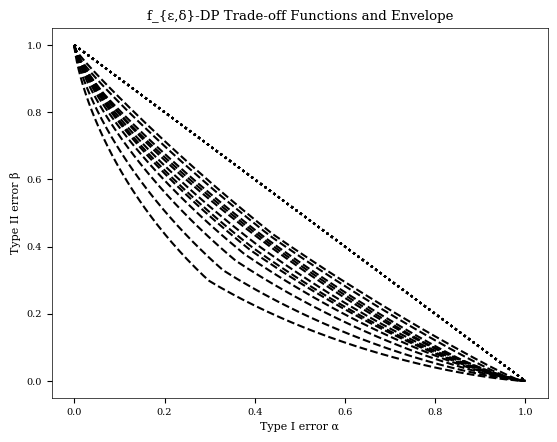

In [ ]:
import matplotlib.pyplot as plt
alpha = np.linspace(0, 1, 2001)  # fine grid of type I error
adv_all = {}
for eps_val, eps_data in data.items():
    adv_por = {}
    for portion, portion_data in eps_data.items():
        f_values = []
        for eps, delta in zip(portion_data[0], portion_data[1]):
            f_values.append(f_eps_delta(alpha, eps, delta))
        f_values = np.array(f_values)
        envelope = np.max(f_values, axis=0)
        # for (eps, delta), f_value in tqdm(zip(zip(portion_data[0], portion_data[1]), f_values)):
        #     plt.plot(alpha, f_value, label=f"ε={eps}, δ={delta}")
        plt.plot(alpha, envelope, 'k--', label='Envelope (max)')
        plt.plot([0,1],[1,0],'k:', label='y=1-x')
        plt.xlabel("Type I error α")
        plt.ylabel("Type II error β")
        plt.title("f_{ε,δ}-DP Trade-off Functions and Envelope")
        adv = np.max((1-alpha) - envelope)
        adv_por[portion] = adv
    adv_all[eps_val] = adv_por
print(adv_all)

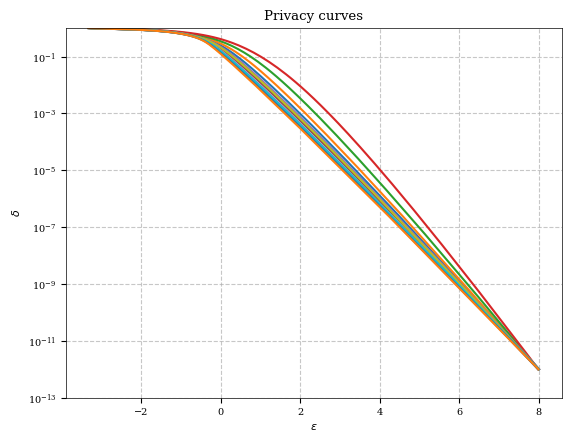

In [96]:

plt.figure()
for eps_value, eps_dict in data.items():
    for por_value, eps_del in eps_dict.items():
        plt.semilogy(eps_del[0], eps_del[1])
plt.xlabel(r"$\epsilon$")
plt.ylabel(r"$\delta$")
plt.ylim(1e-13, 1) 
plt.title("Privacy curves")
plt.grid(True, which="both", ls="--", alpha=0.7)
plt.show()

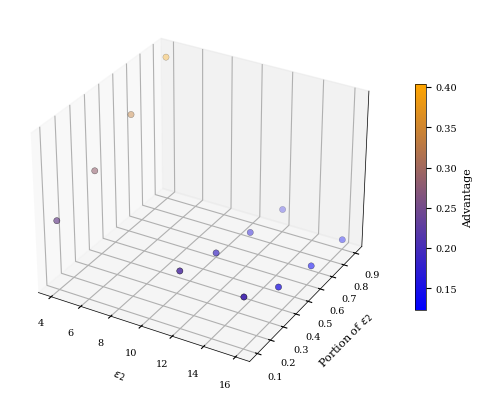

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D)
import matplotlib as mpl
import matplotlib.colors as mcolors
mpl.rcParams["text.usetex"] = False  


# Extract data
epsilons, portions, values = [], [], []
for eps, inner in adv_all.items():
    for portion, val in inner.items():
        epsilons.append(float(eps))
        portions.append(float(portion))
        values.append(float(val))

epsilons = np.array(epsilons)
portions = np.array(portions)
values = np.array(values)

# Matplotlib settings for scientific publication
mpl.rcParams.update({
    "font.family": "serif",
    "font.size": 8,
    "axes.labelsize": 8,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "legend.fontsize": 7,
    "axes.linewidth": 0.5,
})

# Create figure sized for double-column (approx 3.5 inches wide)
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection='3d')

# Normalize colors

# Normalize colors
norm = mpl.colors.Normalize(vmin=np.min(values), vmax=np.max(values))

# Custom colormap from blue → orange
cmap = mcolors.LinearSegmentedColormap.from_list("blue_orange", ["blue", "orange"])

# Scatter plot (no transparency)
sc = ax.scatter(epsilons, portions, values,
                c=values, cmap=cmap, norm=norm,
                s=20, edgecolor='k', linewidth=0.3)

# Labels with proper subscript
ax.set_xlabel(r'$\epsilon_{2}$', labelpad=4)
ax.set_ylabel(r'Portion of $\epsilon_{2}$', labelpad=4)

# Remove z-axis
ax.set_zlabel('')
ax.set_zticks([])

# Colorbar
cbar = fig.colorbar(sc, ax=ax, shrink=0.6, pad=0.05)
cbar.set_label("Advantage", fontsize=8)

# Tight layout
plt.tight_layout()
plt.savefig("/vol/miltank/users/kaiserj/Clipping_vs_Sampling/extra_figs/3d_plot_adv.png", dpi=300)
plt.savefig("/vol/miltank/users/kaiserj/Clipping_vs_Sampling/extra_figs/3d_plot_adv.svg", dpi=300)
plt.show()
